In [53]:
#!pip install numba
#!pip install numba-scipy
#!pip install numba-special==0.1.0
#!pip install tensorflow
#!pip install ipynb-py-convert

In [54]:
import os
import gzip
import numba
import zipfile
import tqdm

import numpy as np
# import numba_scipy
from numba import jit
from numba import njit
import threading as tr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### numba warrnings ###########
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [55]:
# from google.colab import files
# uploaded = files.upload()

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
### path to dataset ###########################################################
#nii_filepath_healthy = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/dataset/healthy/" #nii folder
#nii_filepath_sick = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/dataset/sick/" #7e55febce08fc5f0e53f6a6e6746e7a0.nii" #nii folder

In [58]:
# ############################################
# ### CONVERTER GZIP TO NIFTI ################
# ############################################
### создаем энкодер для файлов gzip
def encoder_gzip2nii_(path, output_path = None):
    os.chdir(path)
    for item in os.listdir(path):
        # print(item)
        if (item.find('.')) > 0:
            # print(str(item.find('.')))
            continue
        else:
            print('Dot not find')
            input = gzip.GzipFile(item)
            # print(item)
            data = input.read()
            input.close()
            # file_output = path + item + ".nii"
            file_output = path + item + ".nii"
            output = open(file_output, 'wb')
            output.write(data)
            output.close()
            os.remove(item)
# encoder_gzip2nii_(nii_filepath_sick, output_path = None)
# encoder_gzip2nii_(nii_filepath_healthy, output_path = None)

In [59]:
import nibabel as nib
from scipy import ndimage
import scipy.special as sc
# import numba_special

In [60]:
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

# from numba import ndimage

# @jit(parallel=True, cache=True, )
def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = np.rot90(img)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

In [61]:
#normal_scan_paths = [
#    os.path.join(os.getcwd(),
#                 nii_filepath_healthy, x) for x in os.listdir(nii_filepath_healthy)
#]
#
#abnormal_scan_paths = [
#    os.path.join(os.getcwd(), 
#                 nii_filepath_sick, x) for x in os.listdir(nii_filepath_sick)]
#
#print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
#print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

In [62]:
# value = len(normal_scan_paths)
# abnormal_scan_paths = abnormal_scan_paths[:value]
# len(abnormal_scan_paths)

In [63]:
### decoder dataset from MRI-image to Numpy Ziparray ##############################################
try:
    os.path.exists("/content/drive/MyDrive/JN/NN/COVID_detection_picture/data/healthy.npz")
    os.path.exists("/content/drive/MyDrive/JN/NN/COVID_detection_picture/data/sick.npz")
    check_h = np.load("/content/drive/MyDrive/JN/NN/COVID_detection_picture/data/healthy.npz")["arr"]
    check_s = np.load("/content/drive/MyDrive/JN/NN/COVID_detection_picture/data/sick.npz")["arr"]
    try:
        normal_scans = check_h
        abnormal_scans = check_s
    except:
        print('Check please, datasets. Do you have NPZ files?')
except:
    from multiprocessing import Pool
    import time
    import tqdm
    if __name__ == '__main__':
        with Pool() as p:
            normal_scans = np.squeeze(np.array(list(tqdm.tqdm(p.imap(process_scan, normal_scan_paths[:value]), total = value))))
            abnormal_scans = np.squeeze(np.array(list(tqdm.tqdm(p.imap(process_scan, abnormal_scan_paths), total = value))))

            
            np.savez_compressed("/content/drive/MyDrive/JN/NN/COVID_detection_picture/data/healthy.npz", 
                                arr = normal_scans)
            np.savez_compressed("/content/drive/MyDrive/JN/NN/COVID_detection_picture/data/sick.npz", 
                                arr = abnormal_scans)

In [64]:
normal_scans.shape, abnormal_scans.shape

((120, 128, 128, 64), (120, 128, 128, 64))

In [65]:
# filepath_sick = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/dataset/train/sick/" #7e55febce08fc5f0e53f6a6e6746e7a0.nii" #nii folder
# filepath_healthy = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/dataset/train/healthy/" #7e55febce08fc5f0e53f6a6e6746e7a0.nii" #nii folder
# image_folder_sick = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/test_model/sick/jpg/"
# image_folder_healthy = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/test_model/healthy/jpg/"

In [66]:
### LABEL's for CLASS #####################
### abnormal == 1 | normal == 0.
###########################################
from numba import cuda
@jit(nopython=True)
def build_labels(abnormal_scans, normal_scans):
    abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
    normal_labels = np.array([0 for _ in range(len(normal_scans))])
    return abnormal_labels, normal_labels
abnormal_labels, normal_labels = build_labels(abnormal_scans, normal_scans)

In [67]:
len(normal_labels), len(abnormal_labels), 

(120, 120)

In [68]:
### Split data in the ratio 70-30 for training and validation.
def spliter_data(abnormal_scans, abnormal_labels, normal_scans, normal_labels, split_size):
    value = len(abnormal_scans) - int(len(abnormal_scans) * split_size)
    # X = np.concatenate((abnormal_scans, normal_scans), axis = 0)
    # np.random.shuffle(X)
    # print(split_size)
    x_train = np.concatenate((abnormal_scans[: value], normal_scans[: value]), axis=0)
    y_train = np.concatenate((abnormal_labels[: value], normal_labels[: value]), axis=0)
    x_val = np.concatenate((abnormal_scans[value: ], normal_scans[value: ]), axis=0)
    y_val = np.concatenate((abnormal_labels[value: ], normal_labels[value: ]), axis=0)
    print(f"Number of samples in train {x_train.shape[0]} and validation {x_val.shape[0]}.")
    return x_train, y_train, x_val, y_val
split_size = 0.2
x_train, y_train, x_val, y_val = spliter_data(abnormal_scans, 
                                              abnormal_labels, 
                                              normal_scans, 
                                              normal_labels, 
                                              split_size)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

Number of samples in train 192 and validation 48.


((192, 128, 128, 64), (192,), (48, 128, 128, 64), (48,))

In [69]:
# ## Data augmentation

# The CT scans also augmented by rotating at random angles during training. Since
# the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
# we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
# the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
# different kinds of preprocessing and augmentation techniques out there,
# this example shows a few simple ones to get started.

In [70]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [71]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
train_loader, validation_loader

(<TensorSliceDataset shapes: ((128, 128, 64), ()), types: (tf.float32, tf.int64)>,
 <TensorSliceDataset shapes: ((128, 128, 64), ()), types: (tf.float32, tf.int64)>)

In [72]:
### convertation to size 128x128x64 and rotation data ###
batch_size = 2 # old =2
train_dataset = (train_loader.shuffle(len(x_train)).map(train_preprocessing).batch(batch_size).prefetch(batch_size))
validation_dataset = (validation_loader.shuffle(len(x_val)).map(validation_preprocessing).batch(batch_size).prefetch(batch_size))
len(train_dataset), len(validation_dataset)

(96, 24)

Visualize an augmented CT scan.

Dimension of the CT scan is: (128, 128, 64, 1)


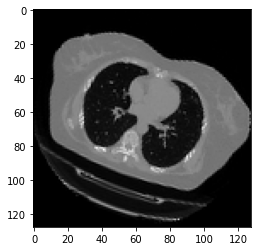

In [73]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray");

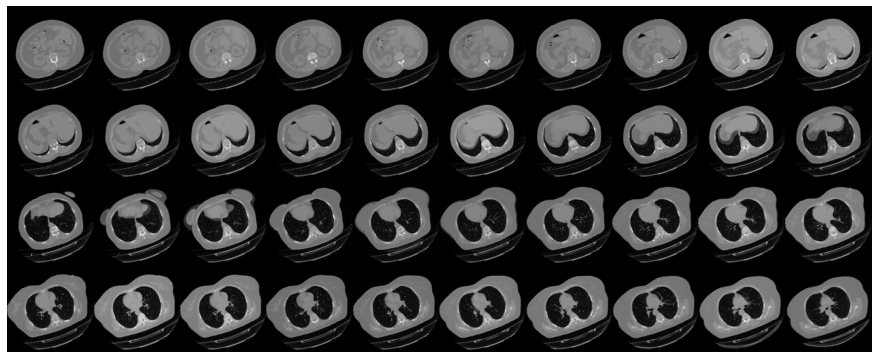

In [74]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

plot_slices(4, 10, 128, 128, image[:, :, :40])

In [75]:
# def get_model(width=128, height=128, depth=64):
  # """Build a 3D convolutional neural network model."""

  #  inputs = keras.Input((width, height, depth, 1))

  # x = layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation="relu")(inputs)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.2)(x)

   # x = layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation="relu")(x)
   # x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.5)(x)
   
  #  x = layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation="relu")(x)
   # x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization(center=True, scale=True)(x)
    #x = layers.Dropout(0.3)(x)

  #  x = layers.Conv3D(filters=128, kernel_size=(3, 3, 3), activation="relu")(x)
   # x = layers.MaxPool3D(pool_size=2)(x)
   #x = layers.BatchNormalization()(x)

   # x = layers.Conv3D(filters=256, kernel_size=(3, 3, 3), activation="relu")(x)
   # x = layers.MaxPool3D(pool_size=2)(x)
   # x = layers.BatchNormalization()(x)

   ## x = layers.GlobalAveragePooling3D()(x)
    #x = layers.Dense(units=512, activation="relu")(x)
   # x = layers.Dropout(0.3)(x)

    #outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
  #  model = keras.Model(inputs, outputs, name="3dcnn")
  #  return model


# Build model.
#model = get_model(width=128, height=128, depth=64)
#model.summary()

In [76]:
def get_model_8L_(width=128, height=128, depth=64):
       """Build a 3D convolutional neural network model."""
       inputs = keras.Input((width, height, depth, 1))

       x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
       x = layers.MaxPool3D(pool_size=2)(x)
       x = layers.BatchNormalization(center=True, scale=True)(x)
  

       x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
       x = layers.MaxPool3D(pool_size=2)(x)
       x = layers.BatchNormalization(center=True, scale=True)(x)
       

      ### add 64N layer ##################################################
       x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
       x = layers.MaxPool3D(pool_size=2)(x)
       x = layers.BatchNormalization(center=True, scale=True)(x)
      

       x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
       x = layers.MaxPool3D(pool_size=1)(x)
       x = layers.BatchNormalization(center=True, scale=True)(x)
       

       x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
       x = layers.MaxPool3D(pool_size=2)(x)
       x = layers.BatchNormalization()(x)

       x = layers.GlobalAveragePooling3D()(x)
       x = layers.Dense(units=512, activation="relu")(x)
       x = layers.Dropout(0.3)(x)

       outputs = layers.Dense(units=1, activation="sigmoid")(x)
      # outputs = layers.Dense(units=1, activation="tanh", )(x)
      # outputs = layers.Dense(units=1, activation="relu", )(x)

       model = keras.Model(inputs, outputs, name="3dcnn")
       return model

model = get_model_8L_()
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 14, 64)    256   

In [77]:
# from keras import backend as K

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [78]:
# ### initial model
# # model = get_model(width=128, height=128, depth = 64)
# model = get_model_8L_(width=128, height=128, depth = 64)
# model.summary()

In [79]:
# Compile model.

metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.Accuracy(name='acc'),
    keras.metrics.BinaryAccuracy(name='b_acc')
]

initial_learning_rate = 0.0015 #0.001 ~val_loss=65! #0.0015 F1=0.68
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

#model.compile(loss = "binary_crossentropy",
#              optimizer = keras.optimizers.Adam(learning_rate = lr_schedule),
#              metrics = metrics)

# model.compile(loss = "binary_crossentropy",
#               optimizer = 'rmsprop',
#               metrics = metrics)

model.compile(loss = "binary_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.0015),
              metrics = metrics)
# Define callbacks.
checkpoint_path = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/Keras/model/"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = keras.callbacks.ModelCheckpoint(checkpoint_dir, 
                                                save_best_only = True,
                                                verbose = 1)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience = 15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(train_dataset,
          validation_data = (validation_dataset),
          epochs = epochs,
          shuffle = True,
          verbose = 2,
        #   batch_size = 32,
          callbacks=[checkpoint_cb, early_stopping_cb]
          )

Epoch 1/100
96/96 - 34s - loss: 0.6879 - fn: 34.0000 - fp: 50.0000 - tn: 46.0000 - tp: 62.0000 - precision: 0.5536 - recall: 0.6458 - acc: 0.0000e+00 - b_acc: 0.5625 - val_loss: 0.7393 - val_fn: 0.0000e+00 - val_fp: 24.0000 - val_tn: 0.0000e+00 - val_tp: 24.0000 - val_precision: 0.5000 - val_recall: 1.0000 - val_acc: 0.0000e+00 - val_b_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.73934, saving model to /content/drive/MyDrive/JN/NN/COVID_detection_picture/Keras/model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/JN/NN/COVID_detection_picture/Keras/model/assets
Epoch 2/100
96/96 - 31s - loss: 0.6708 - fn: 42.0000 - fp: 39.0000 - tn: 57.0000 - tp: 54.0000 - precision: 0.5806 - recall: 0.5625 - acc: 0.0000e+00 - b_acc: 0.5781 - val_loss: 0.9688 - val_fn: 0.0000e+00 - val_fp: 24.0000 - val_tn: 0.0000e+00 - val_tp: 24.0000 - val_precision: 0.5000 - val_recall: 1.0000 - val_acc: 0.0000e+00 - val_b_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.73934
Epoch 3

In [80]:
history = model.history.history
# history

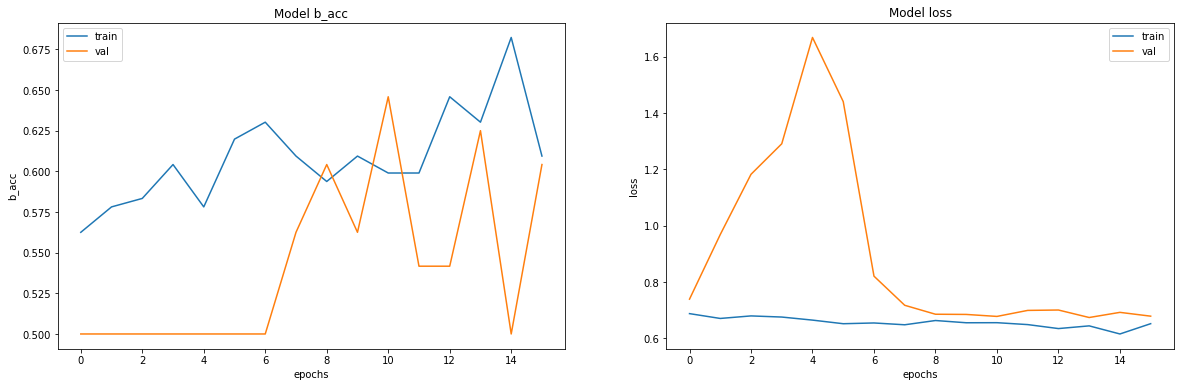

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, metric in enumerate(["b_acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [82]:
y_pred_float = [model.predict(np.expand_dims(x_val[i], axis=0))[0][0] for i in range(0, x_val.shape[0])]
y_pred = np.array([(lambda i: np.int64(1) if model.predict(np.expand_dims(x_val[i], axis = 0))[0][0] > 0.5 else np.int64(0))(i) for i in range(0, x_val.shape[0])])

In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[17,  7],
       [12, 12]])

In [84]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.59      0.71      0.64        24
     class 1       0.63      0.50      0.56        24

    accuracy                           0.60        48
   macro avg       0.61      0.60      0.60        48
weighted avg       0.61      0.60      0.60        48



In [85]:
from sklearn.metrics import roc_curve, auc
roc_curve(y_val.ravel(), y_pred.ravel())


(array([0.        , 0.29166667, 1.        ]),
 array([0. , 0.5, 1. ]),
 array([2, 1, 0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


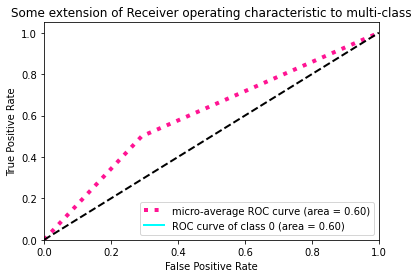

In [86]:
### https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# First aggregate all false positive rates
fpr = dict()
tpr = dict()
roc_auc = dict()

lw = 2
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
fpr, tpr, _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)
all_fpr = np.unique(np.concatenate([fpr for i in range(y_val.shape[0])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
mean_tpr = interp(all_fpr, fpr, tpr)

# Finally average it and compute AUC
mean_tpr /= 1

fpr = all_fpr
tpr = mean_tpr
roc_auc = auc(fpr, tpr)

# Plot all ROC curves
plt.figure()
plt.plot(fpr, tpr,
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='deeppink', linestyle=':', linewidth=4);

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc));

plt.plot([0, 1], [0, 1], 'k--', lw=lw);
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [87]:
tf_rc = tf.keras.metrics.Recall()
tf_rc.update_state(y_val, y_pred)
RECALL = tf_rc.result().numpy()
RECALL

0.5

In [88]:
tf_pr = tf.keras.metrics.Precision()
tf_pr.update_state(y_val, y_pred)
PRECISION = tf_pr.result().numpy()
PRECISION

0.6315789

In [89]:
F1 = (2 * PRECISION * RECALL) / (PRECISION + RECALL)
F1

0.5581395250839305

In [90]:
np.array(y_val).reshape(-1, 1).shape, np.array(y_pred).reshape(-1, 1).shape

((48, 1), (48, 1))

In [91]:
!pip install tensorflow_addons

In [92]:
import tensorflow_addons as tfa

metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes= 1)
metrics.update_state(np.array(y_val).reshape(-1, 1), np.array(y_pred).reshape(-1, 1))
result = metrics.result()
MCC = result.numpy()[0]
MCC

0.21300717

In [93]:
from sklearn.metrics import f1_score
F1_score = f1_score(y_val, y_pred, average='weighted')
F1_score

0.5998244844229925

In [94]:
from sklearn.metrics import f1_score
F1_score = f1_score(y_val, y_pred, average='binary')
F1_score

0.5581395348837209

In [95]:
y_pred[:5], type(y_pred[0])

(array([1, 1, 0, 1, 1]), numpy.int64)

In [96]:
mean_accuracy = np.mean([model.predict(np.expand_dims(x_val[i], axis=0))[0][0] for i in range(0, x_val.shape[0])])
mean_accuracy

0.48205796

This model is 57.03 percent confident that CT scan is normal
Dimension of the CT scan is: (128, 128, 64)
This model is 42.97 percent confident that CT scan is abnormal
Dimension of the CT scan is: (128, 128, 64)


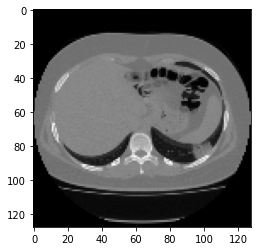

In [97]:
# Load best weights.
# model.load_weights("3d_image_classification.h5")
# loaded_model = keras.models.load_model('C:/Users/Admin/Documents/COVID_detection_picture/Keras/model/model_keras_5L.h5')
# loaded_model = keras.models.load_model('/content/drive/MyDrive/JN/NN/COVID_detection_picture/Keras/model/saved_model.pb')
test_image = x_val[12]
prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(f"This model is {100 * score:.2f} percent confident that CT scan is {name}")
    image = test_image
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

This model is 61.34 percent confident that CT scan is normal
Dimension of the CT scan is: (128, 128, 64)
This model is 38.66 percent confident that CT scan is abnormal
Dimension of the CT scan is: (128, 128, 64)


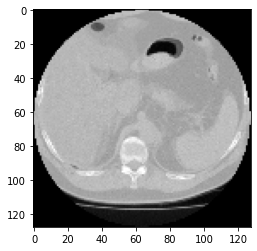

In [98]:
# Load best weights.
# model.load_weights("3d_image_classification.h5")
# loaded_model = keras.models.load_model('/C:/Users/Admin/Documents/COVID_detection_picture/Keras/model/model_keras_5L.h5')
# loaded_model = keras.models.load_model('/content/drive/MyDrive/JN/NN/COVID_detection_picture/Keras/model/saved_model.pb')
path_test_image = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/MRI/sick_nii/sick_7c7160149aec1ebf15b28166f5458c49.nii"
test_image = process_scan(path_test_image)
# model.load_weights("/C:/Users/Admin/Documents/COVID_detection_picture/Keras/model/model_keras_8L_0953.h5")
prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(f"This model is {100 * score:.2f} percent confident that CT scan is {name}")
    image = test_image
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

[0.1152931]
This model is 88.47 percent confident that CT scan is normal
Dimension of the CT scan is: (128, 128, 64)
This model is 11.53 percent confident that CT scan is abnormal
Dimension of the CT scan is: (128, 128, 64)


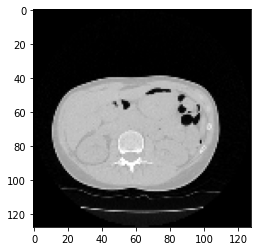

In [99]:
# Load best weights.
# model.load_weights("3d_image_classification.h5")
# loaded_model = keras.models.load_model('/C:/Users/Admin/Documents/COVID_detection_picture/Keras/model/model_keras_5L.h5')
# loaded_model = keras.models.load_model('/content/drive/MyDrive/JN/NN/COVID_detection_picture/Keras/model/saved_model.pb')
# path_test_image = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/dataset/healthy/010722f5ce3929f8d38c961f97da1974.nii"
path_test_image = "/content/drive/MyDrive/JN/NN/COVID_detection_picture/MRI/healthy_nii/health_0a38b4c71a46ce68c8b48c95b93619b2.nii"
test_image = process_scan(path_test_image)
prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
print(prediction)
scores = [1 - prediction[0], prediction[0]]

# class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(f"This model is {100 * score:.2f} percent confident that CT scan is {name}")
    image = test_image
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(np.squeeze(image[:, :, 0]), cmap="gray")

In [100]:
model.save("/content/drive/MyDrive/JN/NN/COVID_detection_picture/Keras/model/model_keras_F1_0819.pb")
model.save("/content/drive/MyDrive/JN/NN/COVID_detection_picture/Keras/model/model_keras_F1_0819.h5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/JN/NN/COVID_detection_picture/Keras/model/model_keras_F1_0819.pb/assets


In [ ]:
#!ipynb-py-convert Keras_COVID_NII_3D_image_classification.ipynb Keras_COVID_NII_3D_image_classification.py

In [ ]:
#!pip install ipynb-py-convert